In [1]:
# imports

import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from matplotlib import pyplot as plt
from pathlib import Path

# stop showing SettingWithCopyWarning
pd.options.mode.chained_assignment = None


In [2]:
# helper functions

def unique_bins(array, n_bins, bounds=None, reverse=False):
    '''This is a function that maps an array of continuous values with potential duplicates to 
    a set of bins in such a way that each of the original continuous values is mapped to a unique bin, and the
    distribution of binned values approximates the distribution of continuous values as closely as possible.
    
    My quick and dirty approach to this problem sorts the input array into the appropriate number of bins. Then,
    starting in the middle and alternating outward left and right, the algorithm checks to see if each bin has 
    more than one resident. If so, it will again alternate outward left and right from that position and allocate
    the extra residents to the nearest free bins.
    
    Parameters
    ----------
    array : np.array
        Sorted array of values to be placed into bins.
    n_bins : int
        Number of bins to use.
    bounds : (float, float)
        Upper and lower bounds to use for bin-mapping.
    reverse : bool
        Optional flag to reverse the index ordering of the output.
    
        
    Returns
    -------
    index : np.array
        Indices indicating mapping of input values to bins, where index[i] indicates the index of the bin 
        mapping of input value array[i] (assuming input array is sorted).
    '''
    # check number of bins
    if not n_bins >= len(array):
        raise ValueError('The number of bins must be >= len(array).')
    # add bounds if supplied
    if bounds is not None:
        array = np.concatenate((array, bounds))
    # make histogram
    counts, _ = np.histogram(array, bins=n_bins)
    # remove bounds if added
    if bounds is not None:
        counts[0] -= 1
        counts[-1] -= 1
    # start from the middle
    i = int(n_bins/2)
    for j in range(n_bins):
        # alternate left and right
        if j % 2:
            i -= j
        else:
            i += j
        # resolve collisions
        if counts[i] > 1:
            # set new counter for exploring nearby positions
            k = i
            for l in range(2*n_bins):
                # alternate left and right
                if l % 2:
                    k -= l
                else:
                    k += l
                # check if we're still in range
                if 0 <= k < n_bins:
                    # check for an empty spot
                    if counts[k] == 0:
                        counts[k] = 1
                        counts[i] -= 1
                        # check if all collisions have been resolved yet
                        if counts[i] == 1:
                            break
    # select indices of non-zero values
    index = np.where(counts == 1)[0]
    # reverse if requested
    if reverse:
        index = (n_bins - 1) - index
    return index


In [3]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF','#FFB1CA', '#4F1DD7']

grays = ['#0F0A0A', '#52525E', '#747688', '#959AB1', '#959AB1', '#CECFD5', '#E0E0E0']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 100

annot_kwgs = {
    'xycoords': 'axes fraction', 'va': 'center', 'ha': 'left', 'fontsize': 22, 'annotation_clip': False
}


# Import data

In [4]:
# read in sample metadata

data_path = Path('../../data/')
out_dir = Path('../../figures/2-mapping/')

# genome metadata
genome_df = pd.read_csv(data_path / 'metadata/genome-metadata.csv')
genome_df.loc[genome_df['Group'] == 'Uncultured-marine-virus', 'Group'] = 'Virus'
genome_df.loc[genome_df['Virocell'], 'Group'] = 'Virocell'

#  ortholog metadata
ortholog_df = pd.read_csv(data_path / 'metadata/ortholog-metadata.csv')

#  sample metadata
sample_df = pd.read_csv(data_path / 'metadata/sample_metadata_merged.csv')
sample_df['Datetime'] = pd.to_datetime(sample_df['Datetime'])
sample_df


,SampleName,Cruise,Year,Datetime,Latitude,Longitude,Depth,Dataset,SampleGroup,TimeFraction,TimeClass,Replicates,Experiment,Condition,Treatment,Timepoint
0,G2.DCM.NS.S11C2.50m,Gradients 2,2017,2017-06-06 06:56:00,36.999833,-158.000,50,Gradients 2 DCM,depth profiles,0.29,6am,1,NaN,NaN,NaN,NaN
1,G2.DCM.NS.S15C2.56m,Gradients 2,2017,2017-06-09 05:30:00,34.000167,-158.000,56,Gradients 2 DCM,depth profiles,0.23,6am,3,NaN,NaN,NaN,NaN
2,G2.DCM.NS.S17C3.87m,Gradients 2,2017,2017-06-10 09:34:00,32.000167,-158.000,87,Gradients 2 DCM,depth profiles,0.40,10am,3,NaN,NaN,NaN,NaN
3,G2.DCM.NS.S18C2.95m,Gradients 2,2017,2017-06-11 05:50:00,29.582000,-158.002,95,Gradients 2 DCM,depth profiles,0.24,6am,3,NaN,NaN,NaN,NaN
4,G3.DEPTH.NS.S4C6.75m,Gradients 3,2019,2019-04-16 08:00:00,41.670000,-158.050,75,Gradients 3 depth profile,depth profiles,0.33,10am,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,G3.DEPTH.NS.S6C7.15m,Gradients 3,2019,2019-04-22 06:44:00,32.920000,-158.000,15,Gradients 3 depth profile,surface transect,0.28,6am,2,NaN,NaN,NaN,NaN
83,G3.UW.NS.UW40_1.7m,Gradients 3,2019,2019-04-24 05:57:00,40.880000,-158.000,7,Gradients 3 underway,surface transect,0.25,6am,3,NaN,NaN,NaN,NaN
84,G3.DEPTH.NS.S8C2.15m,Gradients 3,2019,2019-04-24 14:47:00,42.330000,-158.000,15,Gradients 3 depth profile,surface transect,0.62,2pm,2,NaN,NaN,NaN,NaN
85,G3.UW.NS.UW40_2.7m,Gradients 3,2019,2019-04-25 06:01:00,40.090000,-158.000,7,Gradients 3 underway,surface transect,0.25,6am,3,NaN,NaN,NaN,NaN


In [5]:
# read in mapped transcript abundance data

mappings_df = pd.read_csv(data_path / '2-mapping/collated_salmon_data.csv.gz')
mappings_df


,MappingName,GeneLength,TPM,NumReads,SampleID,GenomeName,GeneID
0,AG-316-L16_2717627218,1116,0.0,0.0,G3.DIEL.NS.S4C21.15m.A,AG-316-L16,2717627218
1,AG-316-L16_2717627219,1290,0.0,0.0,G3.DIEL.NS.S4C21.15m.A,AG-316-L16,2717627219
2,AG-316-L16_2717627220,1578,0.0,0.0,G3.DIEL.NS.S4C21.15m.A,AG-316-L16,2717627220
3,AG-316-L16_2717627221,99,0.0,0.0,G3.DIEL.NS.S4C21.15m.A,AG-316-L16,2717627221
4,AG-316-L16_2717627222,1050,0.0,0.0,G3.DIEL.NS.S4C21.15m.A,AG-316-L16,2717627222
...,...,...,...,...,...,...,...
219859471,Syn9_638323192,228,0.0,0.0,G3.DIEL.NS.S4C13.15m.B,Syn9,638323192
219859472,Syn9_638323193,711,0.0,0.0,G3.DIEL.NS.S4C13.15m.B,Syn9,638323193
219859473,Syn9_638323194,180,0.0,0.0,G3.DIEL.NS.S4C13.15m.B,Syn9,638323194
219859474,Syn9_638323195,231,0.0,0.0,G3.DIEL.NS.S4C13.15m.B,Syn9,638323195


# Process mapped reads

In [6]:
# look at read mappings per group and clade

pangenome_df = mappings_df[['MappingName', 'SampleID', 'GenomeName', 'NumReads']]

# add genus, clade, and ortholog info to dataframe
pangenome_df['Group'] = pangenome_df['GenomeName'].map(genome_df.set_index('GenomeName')['Group'])
pangenome_df['Clade'] = pangenome_df['GenomeName'].map(genome_df.set_index('GenomeName')['Clade'])
pangenome_df['CyCOGID'] = pangenome_df['MappingName'].map(ortholog_df.set_index('MappingName')['CyCOGID'])

# look at what percentage of reads mapped to each group
total_reads = pangenome_df.NumReads.sum()
print(pangenome_df.groupby('Group').NumReads.sum() / total_reads * 100)
print(pangenome_df.groupby('Clade').NumReads.sum() / total_reads * 100)

# down-select to only references that aren't a virus or virocell
drop_references = genome_df[genome_df['Group'].isin(['Virus', 'Virocell'])].GenomeName.to_list()
pangenome_df = pangenome_df[~pangenome_df.GenomeName.isin(drop_references)]

# make dataframe of all reads aggregated by clade within each sample
clade_abun_df = pangenome_df.groupby(['SampleID', 'Group', 'Clade']).NumReads.sum().reset_index().rename(
    columns={'NumReads': 'CladeReads'})
clade_abun_df['SampleReads'] = clade_abun_df['SampleID'].map(clade_abun_df.groupby('SampleID').CladeReads.sum())
clade_abun_df['RelativeAbundance'] = clade_abun_df['CladeReads'] / clade_abun_df['SampleReads']


Group
Prochlorococcus    74.293742
Synechococcus      25.253400
Virocell            0.221094
Virus               0.231763
Name: NumReads, dtype: float64
Clade
5.1A-CRD2             2.408631
5.1A-II               0.782678
5.1A-III              0.687587
5.1A-IV               6.526581
5.1A-UC-A-EnvC        0.520610
5.1A-WPC1             0.056972
5.1A-unclassified     1.453333
5.1B-CRD1             2.522084
5.1B-I                3.675507
5.1B-IX               0.474245
5.1B-V                0.011513
5.1B-VI               0.011001
5.1B-VIII             0.021663
5.2                   2.255332
5.3                   3.838924
AMZ-II                0.067147
HLI                  29.302710
HLII                 18.132642
HLII.HLVI             0.108533
HLIII                 1.556537
HLIII.HLIV.HLV        0.052397
HLIV                  1.160053
HLVI                  0.270274
LLI                  12.715743
LLI.LLVIII            0.267615
LLII.LLIII            2.473723
LLIV                  0.294194
LLVI

In [7]:
# collect reads mapping to known orthologs only and aggregate within orthologs

# down-select to only the genes with an ortholog mapping
pangenome_df = pangenome_df[~pangenome_df['CyCOGID'].isna()]

# aggregate all orthologs in same clade
pangenome_df = pangenome_df.groupby(['SampleID', 'Group', 'Clade', 'CyCOGID']).agg(Reads=('NumReads', 'sum')).reset_index()

# identify nonzero mappings (at least one read mapped to ortholog-sample-clade)
pangenome_df['Nonzero'] = pangenome_df['Reads'].gt(0.0)

pangenome_df


,SampleID,Group,Clade,CyCOGID,Reads,Nonzero
0,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,AMZ-II,60000002.0,0.0,False
1,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,AMZ-II,60000003.0,0.0,False
2,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,AMZ-II,60000004.0,0.0,False
3,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,AMZ-II,60000005.0,0.0,False
4,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,AMZ-II,60000006.0,0.0,False
...,...,...,...,...,...,...
21899629,G3.UW.NS.UW40_2.7m.C,Synechococcus,Unclassified,60039505.0,0.0,False
21899630,G3.UW.NS.UW40_2.7m.C,Synechococcus,Unclassified,60039506.0,1.0,True
21899631,G3.UW.NS.UW40_2.7m.C,Synechococcus,Unclassified,60039507.0,0.0,False
21899632,G3.UW.NS.UW40_2.7m.C,Synechococcus,Unclassified,60039508.0,0.0,False


In [8]:
# calculate genome coverage in each sample

clade_abun_df['PangenomeSize'] = clade_abun_df['Clade'].map(pangenome_df.groupby(['Clade']).CyCOGID.nunique())
clade_abun_df['DetectedPangenomeSize'] = clade_abun_df['Clade'].map(
    pangenome_df[pangenome_df.Nonzero].groupby(['Clade']).CyCOGID.nunique())
clade_abun_df = pd.merge(
    clade_abun_df, 
    pangenome_df.groupby(['SampleID', 'Clade']).Nonzero.sum().reset_index().rename(columns={'Nonzero':'DetectedCyCOGs'}), 
    on=['SampleID', 'Clade'], 
    how='left'
)
clade_abun_df['PangenomeCoverage'] = clade_abun_df['DetectedCyCOGs'] / clade_abun_df['PangenomeSize']
clade_abun_df['DetectedPangenomeCoverage'] = clade_abun_df['DetectedCyCOGs'] / clade_abun_df['DetectedPangenomeSize']

# save as csv
clade_abun_df.to_csv(data_path / '2-mapping/aggregate-clade-reads.csv', index=False)

# separate sample name and replicates
abun_df = pd.merge(clade_abun_df, clade_abun_df['SampleID'].str.rsplit('.', n=1, expand=True), left_index=True, right_index=True).rename(
    columns={0: 'SampleName', 1: 'Replicate'}
)

# add in sample data
abun_df = pd.merge(
    abun_df, sample_df, left_on='SampleName', right_on='SampleName', how='left'
)
abun_df


,SampleID,Group,Clade,CladeReads,SampleReads,RelativeAbundance,PangenomeSize,DetectedPangenomeSize,DetectedCyCOGs,PangenomeCoverage,...,Depth,Dataset,SampleGroup,TimeFraction,TimeClass,Replicates,Experiment,Condition,Treatment,Timepoint
0,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,AMZ-II,507.205,5392534.276,0.000094,1762,127,0,0.000000,...,15,Gradients 1 surface,surface transect,0.24,6am,3,NaN,NaN,NaN,NaN
1,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLI,272443.296,5392534.276,0.050522,4906,3906,575,0.117203,...,15,Gradients 1 surface,surface transect,0.24,6am,3,NaN,NaN,NaN,NaN
2,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLII,4792471.907,5392534.276,0.888723,6997,4787,1740,0.248678,...,15,Gradients 1 surface,surface transect,0.24,6am,3,NaN,NaN,NaN,NaN
3,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLII.HLVI,34148.879,5392534.276,0.006333,1822,1144,146,0.080132,...,15,Gradients 1 surface,surface transect,0.24,6am,3,NaN,NaN,NaN,NaN
4,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLIII,24885.537,5392534.276,0.004615,1652,221,11,0.006659,...,15,Gradients 1 surface,surface transect,0.24,6am,3,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6433,G3.UW.NS.UW40_2.7m.C,Synechococcus,5.1B-VI,379.143,6466463.567,0.000059,2564,226,8,0.003120,...,7,Gradients 3 underway,surface transect,0.25,6am,3,NaN,NaN,NaN,NaN
6434,G3.UW.NS.UW40_2.7m.C,Synechococcus,5.1B-VIII,2009.257,6466463.567,0.000311,2515,239,3,0.001193,...,7,Gradients 3 underway,surface transect,0.25,6am,3,NaN,NaN,NaN,NaN
6435,G3.UW.NS.UW40_2.7m.C,Synechococcus,5.2,267334.246,6466463.567,0.041342,5123,481,13,0.002538,...,7,Gradients 3 underway,surface transect,0.25,6am,3,NaN,NaN,NaN,NaN
6436,G3.UW.NS.UW40_2.7m.C,Synechococcus,5.3,1016616.381,6466463.567,0.157214,2783,526,2,0.000719,...,7,Gradients 3 underway,surface transect,0.25,6am,3,NaN,NaN,NaN,NaN


# Plot pangenome sizes

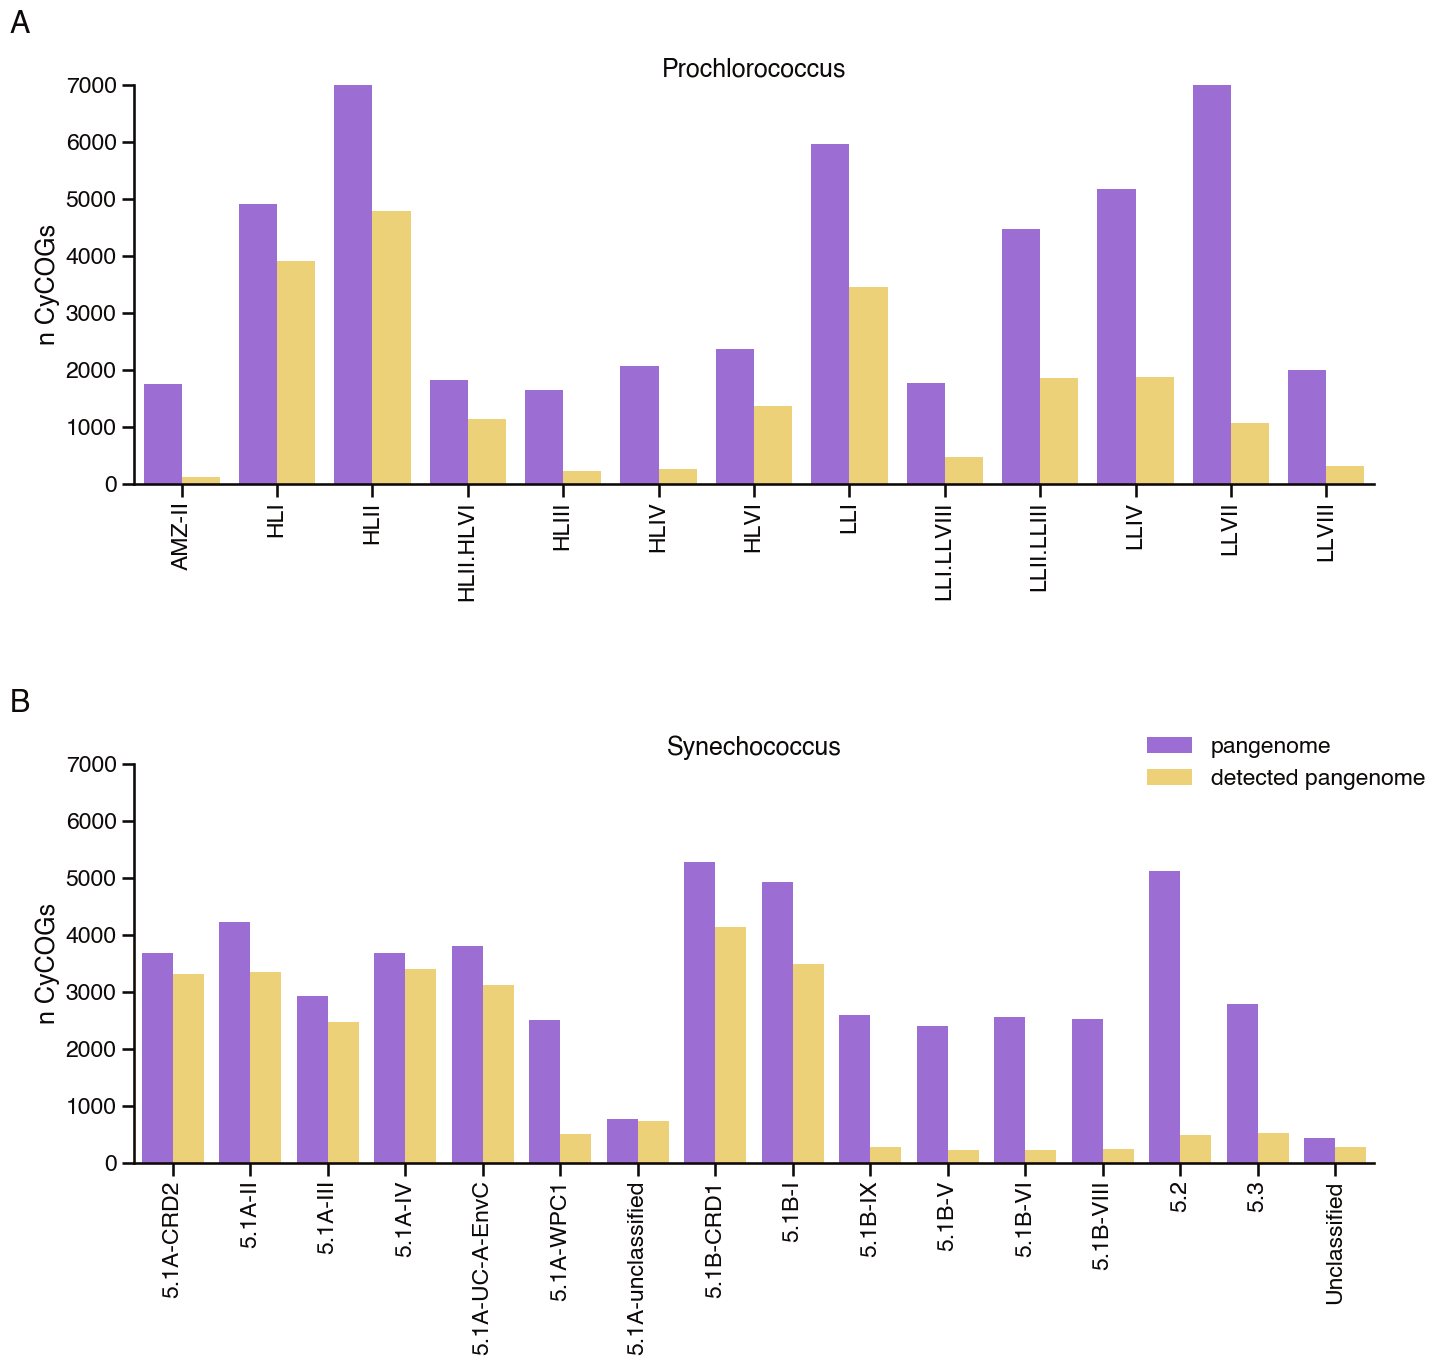

In [9]:
# plot pangenome size by clade

# By means of comparison, in Zinser et al., 2009, they found that 89% of the protein coding genes of MED4 
# (1511/1698) were detectibly expressed at some point over the 24h cycle. https://doi.org/10.1371/journal.pone.0005135

# set up data
data_df = abun_df[['Group', 'Clade', 'PangenomeSize', 'DetectedPangenomeSize']].drop_duplicates()
data_df = data_df.melt(
    id_vars=['Group', 'Clade'], value_vars=['PangenomeSize', 'DetectedPangenomeSize'], var_name='category', value_name='n CyCOGs'
)
data_df['category'] = data_df['category'].map({'PangenomeSize': 'pangenome', 'DetectedPangenomeSize': 'detected pangenome'})

# set up figure
fig = plt.figure(figsize=(16, 14))
grid = plt.GridSpec(2, 1, hspace=.7)
annot_kwgs = {
    'xycoords': 'axes fraction', 'va': 'center', 'ha': 'left', 'fontsize': 22, 'annotation_clip': False
}

# plot data
for i, genus in enumerate(['Prochlorococcus', 'Synechococcus']): 
    # set up subplot
    axis = plt.subplot(grid[i,0])
    axis.annotate({0:'A', 1:'B'}[i], xy=(-0.1, 1.15), **annot_kwgs)
    # set up subplot data
    plot_df = data_df[data_df['Group'] == genus].sort_values('Clade')
    sns.barplot(
        plot_df, x='Clade', y='n CyCOGs', hue='category', palette=[sns.color_palette()[i] for i in [0, 6]], legend=(i==1), ax=axis
    ); 
    # fix axes
    axis.set_xticks(axis.get_xticks(), axis.get_xticklabels(), rotation=90)
    axis.set(ylim=(0, 7000), xlabel='', title=genus)
    # fix legend
    if i: 
        axis.legend(title='', loc='center left', bbox_to_anchor=(0.8, 1))

plt.show()


# Plot aggregate clade reads

In [10]:
# generate aggregate transcript reads per sample by genus

genus_abun_df = abun_df.groupby(['SampleID', 'SampleName', 'Group']).CladeReads.sum().reset_index().rename(
    columns={'CladeReads': 'GenusReads'}
)
genus_abun_df = pd.merge(
    genus_abun_df, sample_df, on='SampleName', how='left'
)

# separate out Pro & Syn
pro_abun_df = genus_abun_df[genus_abun_df['Group'] == 'Prochlorococcus']
syn_abun_df = genus_abun_df[genus_abun_df['Group'] == 'Synechococcus']

genus_abun_df


,SampleID,SampleName,Group,GenusReads,Cruise,Year,Datetime,Latitude,Longitude,Depth,Dataset,SampleGroup,TimeFraction,TimeClass,Replicates,Experiment,Condition,Treatment,Timepoint
0,G1.SURF.NS.S02C1.15m.A,G1.SURF.NS.S02C1.15m,Prochlorococcus,5233756.495,Gradients 1,2016,2016-04-20 05:51:00,23.495833,-157.994333,15,Gradients 1 surface,surface transect,0.24,6am,3,NaN,NaN,NaN,NaN
1,G1.SURF.NS.S02C1.15m.A,G1.SURF.NS.S02C1.15m,Synechococcus,158777.781,Gradients 1,2016,2016-04-20 05:51:00,23.495833,-157.994333,15,Gradients 1 surface,surface transect,0.24,6am,3,NaN,NaN,NaN,NaN
2,G1.SURF.NS.S02C1.15m.B,G1.SURF.NS.S02C1.15m,Prochlorococcus,8848526.865,Gradients 1,2016,2016-04-20 05:51:00,23.495833,-157.994333,15,Gradients 1 surface,surface transect,0.24,6am,3,NaN,NaN,NaN,NaN
3,G1.SURF.NS.S02C1.15m.B,G1.SURF.NS.S02C1.15m,Synechococcus,215674.011,Gradients 1,2016,2016-04-20 05:51:00,23.495833,-157.994333,15,Gradients 1 surface,surface transect,0.24,6am,3,NaN,NaN,NaN,NaN
4,G1.SURF.NS.S02C1.15m.C,G1.SURF.NS.S02C1.15m,Prochlorococcus,7364384.014,Gradients 1,2016,2016-04-20 05:51:00,23.495833,-157.994333,15,Gradients 1 surface,surface transect,0.24,6am,3,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,G3.UW.NS.UW40_2.7m.A,G3.UW.NS.UW40_2.7m,Synechococcus,1800562.929,Gradients 3,2019,2019-04-25 06:01:00,40.090000,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,3,NaN,NaN,NaN,NaN
440,G3.UW.NS.UW40_2.7m.B,G3.UW.NS.UW40_2.7m,Prochlorococcus,2828750.550,Gradients 3,2019,2019-04-25 06:01:00,40.090000,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,3,NaN,NaN,NaN,NaN
441,G3.UW.NS.UW40_2.7m.B,G3.UW.NS.UW40_2.7m,Synechococcus,1523669.922,Gradients 3,2019,2019-04-25 06:01:00,40.090000,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,3,NaN,NaN,NaN,NaN
442,G3.UW.NS.UW40_2.7m.C,G3.UW.NS.UW40_2.7m,Prochlorococcus,4184625.059,Gradients 3,2019,2019-04-25 06:01:00,40.090000,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,3,NaN,NaN,NaN,NaN


In [11]:
# generate compositional dataset

comp_df = pd.merge(abun_df, genus_abun_df[['SampleID', 'Group', 'GenusReads']], on=['SampleID', 'Group'], how='left')
comp_df['CladeProportionReads'] = comp_df['CladeReads'] / comp_df['GenusReads']

comp_df

,SampleID,Group,Clade,CladeReads,SampleReads,RelativeAbundance,PangenomeSize,DetectedPangenomeSize,DetectedCyCOGs,PangenomeCoverage,...,SampleGroup,TimeFraction,TimeClass,Replicates,Experiment,Condition,Treatment,Timepoint,GenusReads,CladeProportionReads
0,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,AMZ-II,507.205,5392534.276,0.000094,1762,127,0,0.000000,...,surface transect,0.24,6am,3,NaN,NaN,NaN,NaN,5233756.495,0.000097
1,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLI,272443.296,5392534.276,0.050522,4906,3906,575,0.117203,...,surface transect,0.24,6am,3,NaN,NaN,NaN,NaN,5233756.495,0.052055
2,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLII,4792471.907,5392534.276,0.888723,6997,4787,1740,0.248678,...,surface transect,0.24,6am,3,NaN,NaN,NaN,NaN,5233756.495,0.915685
3,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLII.HLVI,34148.879,5392534.276,0.006333,1822,1144,146,0.080132,...,surface transect,0.24,6am,3,NaN,NaN,NaN,NaN,5233756.495,0.006525
4,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLIII,24885.537,5392534.276,0.004615,1652,221,11,0.006659,...,surface transect,0.24,6am,3,NaN,NaN,NaN,NaN,5233756.495,0.004755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6433,G3.UW.NS.UW40_2.7m.C,Synechococcus,5.1B-VI,379.143,6466463.567,0.000059,2564,226,8,0.003120,...,surface transect,0.25,6am,3,NaN,NaN,NaN,NaN,2281838.508,0.000166
6434,G3.UW.NS.UW40_2.7m.C,Synechococcus,5.1B-VIII,2009.257,6466463.567,0.000311,2515,239,3,0.001193,...,surface transect,0.25,6am,3,NaN,NaN,NaN,NaN,2281838.508,0.000881
6435,G3.UW.NS.UW40_2.7m.C,Synechococcus,5.2,267334.246,6466463.567,0.041342,5123,481,13,0.002538,...,surface transect,0.25,6am,3,NaN,NaN,NaN,NaN,2281838.508,0.117157
6436,G3.UW.NS.UW40_2.7m.C,Synechococcus,5.3,1016616.381,6466463.567,0.157214,2783,526,2,0.000719,...,surface transect,0.25,6am,3,NaN,NaN,NaN,NaN,2281838.508,0.445525


## _Prochlorococcus_

Clade
AMZ-II         2.632253
HLI           98.399943
HLII          95.978795
HLII.HLVI      1.965143
HLIII          8.297959
HLIV           8.810219
HLVI           2.625538
LLI           96.694523
LLI.LLVIII     1.740387
LLII.LLIII    27.161314
LLIV           6.188290
LLVII         43.735180
LLVIII         0.636836
Name: CladeProportionReads, dtype: float64

Clades combined as 'Other': ['AMZ-II', 'HLII.HLVI', 'HLIII.HLIV.HLV', 'HLVI', 'LLI.LLVIII', 'LLVIII']
Max proportion 'Other' reads: 5.23% in sample G2.BEXP1.NS.DHPS.T96



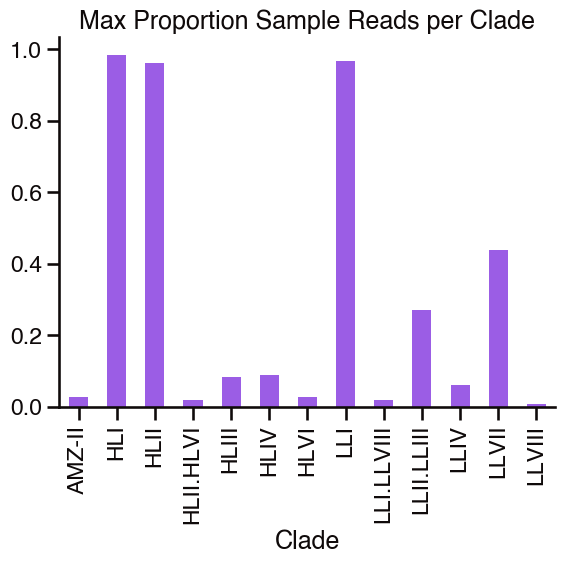

In [12]:
# get Pro community composition data together

pro_comp_df = comp_df[comp_df['Group'] == 'Prochlorococcus']
pro_comp_df = pro_comp_df.groupby(['SampleName', 'Clade'])['CladeProportionReads'].mean().reset_index()
max_reads = pro_comp_df.groupby('Clade').CladeProportionReads.max()
print(max_reads * 100)
max_reads.plot(kind='bar', title='Max Proportion Sample Reads per Clade')

# replace low abundance clades with "other" label
others = ['AMZ-II', 'HLII.HLVI', 'HLIII.HLIV.HLV', 'HLVI', 'LLI.LLVIII', 'LLVIII']
pro_comp_df.loc[pro_comp_df['Clade'].isin(others), 'Clade'] = 'Other'
pro_comp_df = pro_comp_df.groupby(['SampleName', 'Clade'])['CladeProportionReads'].sum().reset_index()
max_other = pro_comp_df.loc[pro_comp_df[pro_comp_df.Clade == 'Other'].CladeProportionReads.idxmax(), :]
print(f"\nClades combined as 'Other': {others}")
print(f"Max proportion 'Other' reads: {max_other['CladeProportionReads']*100:.2f}% in sample {max_other['SampleName']}\n")

# add back sample metadata
pro_comp_df = pd.merge(pro_comp_df, sample_df, on='SampleName', how='left')


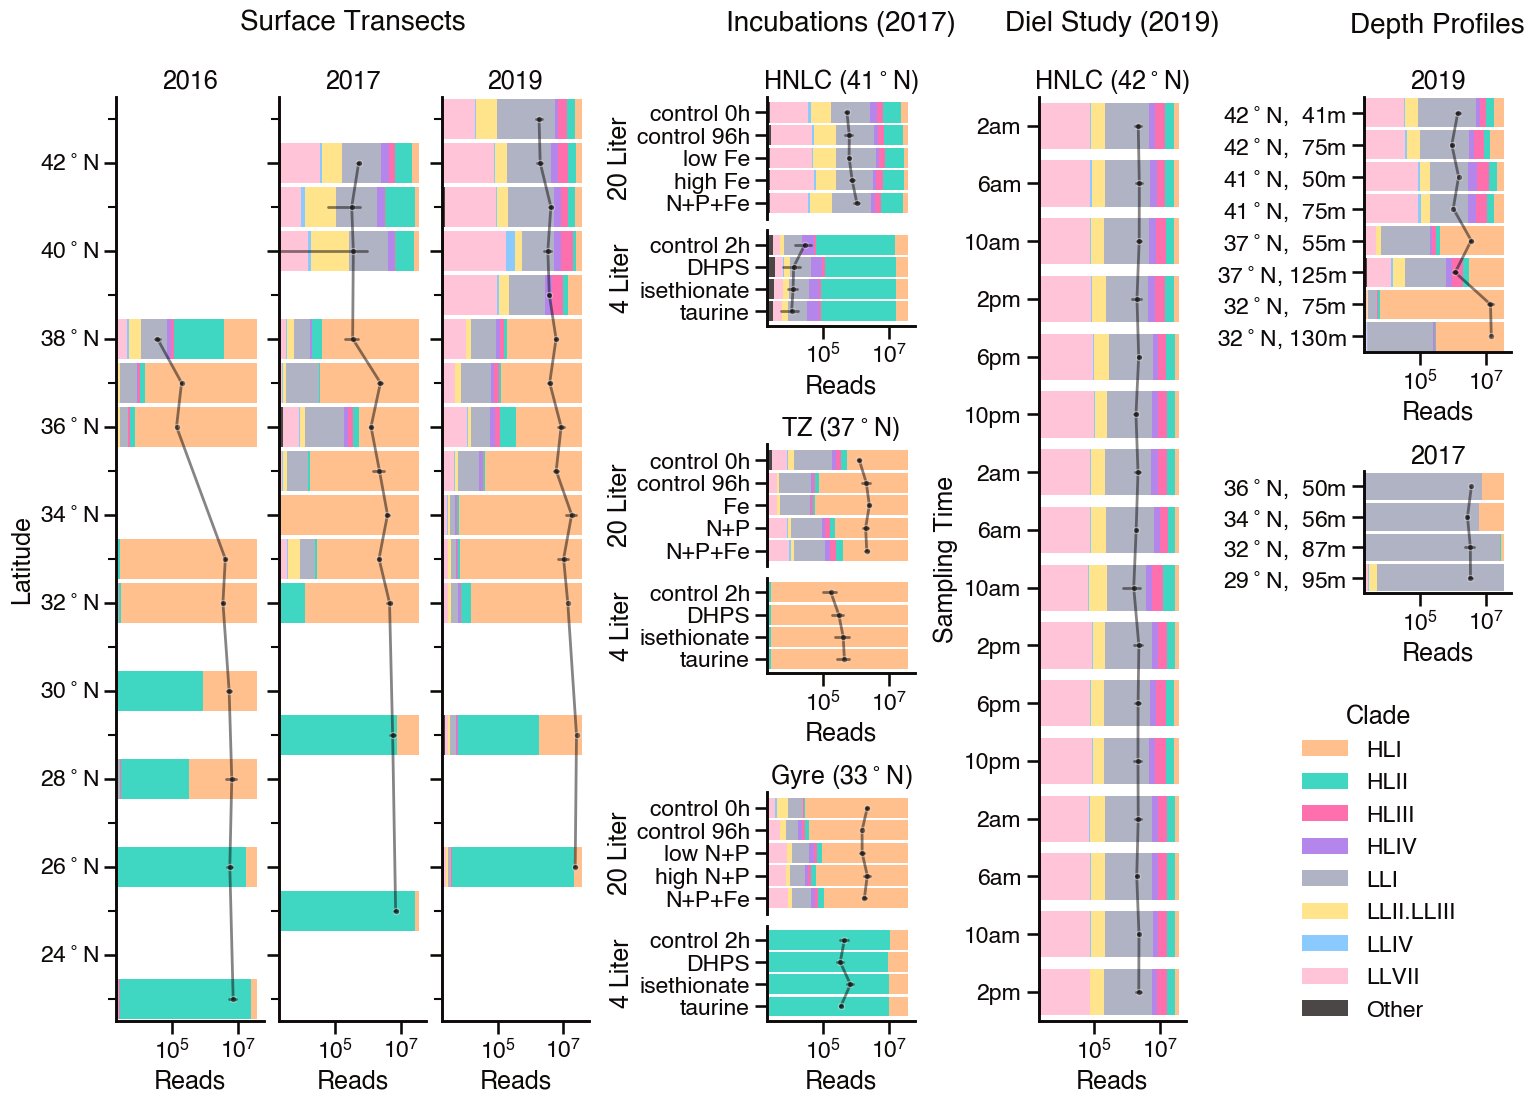

In [13]:
# Plot Prochlorococcus commmunity abundances

# set up figure
fig = plt.figure(figsize=(18, 12))
rows = 35
cols = 26
grid = plt.GridSpec(rows, cols, wspace=0.4, hspace=.8)
xlim = (2000, 60000000)
color_palette = [sns.color_palette()[i] for i in [1, 2, 3, 0, 5, 6, 7, 8, 4]]
annot_kwgs = {
    'xycoords': 'axes fraction', 'va': 'center', 'ha': 'left', 'fontsize': 22, 'annotation_clip': False
}

# plot surface transect data
n_bins = 21
bounds = (23, 43)
for i, year in enumerate([2016, 2017, 2019]):
    axis = plt.subplot(grid[:, 3*i:3*(i+1)])
    if i == 1:
        axis.annotate('Surface Transects', xy=(.5, 1.08), xycoords='axes fraction', va='center', ha='center', fontsize=20)
    # plot community composition
    plot_df = pro_comp_df[(pro_comp_df['Year'] == year) & (pro_comp_df['SampleGroup'] == 'surface transect')]
    latitudes = plot_df[
        ['SampleName', 'Latitude']].drop_duplicates().set_index('SampleName').sort_values('Latitude')['Latitude']
    lat_bins = unique_bins(latitudes, n_bins, bounds=bounds, reverse=False)
    plot_df['lat_idx'] = plot_df['SampleName'].map(dict(zip(latitudes.index, lat_bins)))
    sns.histplot(
        data=plot_df, y='lat_idx', hue='Clade', weights='CladeProportionReads', multiple='stack', 
        palette=color_palette, bins=n_bins, binrange=(-0.5, n_bins-0.5), legend=False, shrink=0.9, ax=axis
    )
    if not i:
        axis.set_yticks(np.arange(1, n_bins, 2), [f'{l}$^\circ$N' for l in np.arange(bounds[0]+1, bounds[1], 2)])
        axis.set(xlabel='', ylabel='Latitude', ylim=(-0.5, n_bins-0.5), title=year)
    else: 
        axis.set_yticks(np.arange(1, n_bins, 2))
        axis.tick_params(labelleft=False)
        axis.set(xlabel='', ylabel='', ylim=(-0.5, n_bins-0.5), title=year)
    axis.set_yticks(np.arange(n_bins), minor=True)
    # plot total read abundance
    plot_df = pro_abun_df[(pro_abun_df['Year'] == year) & (pro_abun_df['SampleGroup'] == 'surface transect')]
    plot_df['lat_idx'] = plot_df['SampleName'].map(dict(zip(latitudes.index, lat_bins)))
    axis2 = plt.twiny(axis)
    sns.lineplot(
        plot_df, x='GenusReads', y='lat_idx', estimator='mean', errorbar='sd', err_style='bars', orient='y', 
        color=sns.color_palette()[4], alpha=0.5, marker='.', ax=axis2
    )
    axis.tick_params(bottom=False, labelbottom=False)
    axis2.xaxis.set_label_position('bottom')
    axis2.xaxis.tick_bottom()
    axis2.set(xscale='log', xlabel='Reads', xlim=xlim)

# plot incubation data
incubation_treatment_order = {
    'HNLC': {'rr': ['control 0h', 'control 96h', 'low Fe', 'high Fe', 'N+P+Fe'], 'bryn': ['control 2h', 'DHPS', 'isethionate', 'taurine']}, 
    'TZ': {'rr': ['control 0h', 'control 96h', 'Fe', 'N+P', 'N+P+Fe'], 'bryn': ['control 2h', 'DHPS', 'isethionate', 'taurine']}, 
    'gyre': {'rr': ['control 0h', 'control 96h', 'low N+P', 'high N+P', 'N+P+Fe'], 'bryn': ['control 2h', 'DHPS', 'isethionate', 'taurine']}
}
inc_titles = {
    'rr': {'HNLC': 'HNLC (41$^\circ$N)', 'TZ': 'TZ (37$^\circ$N)', 'gyre': 'Gyre (33$^\circ$N)'}, 
    'bryn': {'HNLC': '', 'TZ': '', 'gyre': ''}
}
for i, condition in enumerate(['HNLC', 'TZ', 'gyre']):
    axtop = plt.subplot(grid[13*i:5+(13*i), 12:15]) # 0:5, 13:18, 26:31
    axbottom = plt.subplot(grid[5+(13*i):9+(13*i), 12:15]) # 5:9, 18:22, 31:35
    if not i:
        axtop.annotate('Incubations (2017)', xy=(0.5, 1.6), xycoords='axes fraction', 
                      va='center', ha='center', fontsize=20)
    # get data togehter
    comp_data_df = pro_comp_df[pro_comp_df['Condition'] == condition]
    abun_data_df = pro_abun_df[pro_abun_df['Condition'] == condition]
    for dataset in ['rr', 'bryn']:
        axis = {'rr': axtop, 'bryn': axbottom}[dataset]
        if dataset == 'rr':
            comp_plot_df = comp_data_df[comp_data_df['Dataset'] != 'Bryn amendment incubation']
            abun_plot_df = abun_data_df[abun_data_df['Dataset'] != 'Bryn amendment incubation']
        elif dataset == 'bryn':
            comp_plot_df = comp_data_df[comp_data_df['Dataset'] == 'Bryn amendment incubation']
            abun_plot_df = abun_data_df[abun_data_df['Dataset'] == 'Bryn amendment incubation']
        # plot composition
        comp_plot_df['Treatment'] = pd.Categorical(comp_plot_df['Treatment'], incubation_treatment_order[condition][dataset])
        sns.histplot(
            data=comp_plot_df.sort_values(['Treatment', 'Clade']), y='Treatment', hue='Clade', weights='CladeProportionReads', 
            multiple='stack', palette=color_palette, legend=False, shrink=0.9, ax=axis
        )
        # plot total read abundance
        axis2 = plt.twiny(axis)
        abun_plot_df['Treatment'] = pd.Categorical(abun_plot_df['Treatment'], incubation_treatment_order[condition][dataset])
        sns.lineplot(
            abun_plot_df.sort_values('Treatment'), x='GenusReads', y='Treatment', estimator='mean', errorbar='sd', err_style='bars', 
            orient='y', color=sns.color_palette()[4], alpha=0.5, marker='.', ax=axis2
        )
        # fix labels and ticks
        axis.set(xlabel='', ylabel={'rr': '20 Liter', 'bryn': '4 Liter'}[dataset], title=inc_titles[dataset][condition])
        axis.tick_params(bottom=False, labelbottom=False)
        axis2.xaxis.set_label_position('bottom')
        axis2.xaxis.tick_bottom()
        if dataset == 'rr':
            axis.spines[['bottom']].set_visible(False)
            axis2.spines[['bottom']].set_visible(False)
            axis2.set(xscale='log', xlabel='', xlim=xlim)
            axis2.tick_params(bottom=False, labelbottom=False, which='both')
        elif dataset == 'bryn':
            axis2.set(xscale='log', xlabel='Reads', xlim=xlim)

# plot diel data
axis = plt.subplot(grid[:, 17:20])
axis.annotate('Diel Study (2019)', xy=(0.5, 1.08), xycoords='axes fraction', va='center', ha='center', fontsize=20)
# plot community composition
plot_df = pro_comp_df[pro_comp_df['SampleGroup'] == 'diel study'].sort_values(['Datetime', 'Clade'], ascending=[False, True])
n_samples = plot_df['SampleName'].nunique()
plot_df['idx'] = plot_df['SampleName'].map(dict(zip(plot_df['SampleName'].unique(), np.arange(n_samples))))
sns.histplot(
    data=plot_df, y='idx', hue='Clade', weights='CladeProportionReads', 
    multiple='stack', palette=color_palette, bins=n_samples, binrange=(-0.5, n_samples-0.5), legend=False, shrink=0.8, ax=axis
)
axis.set(xlabel='', ylabel='Sampling Time', ylim=(-0.5, n_samples-0.5), title='HNLC (42$^\circ$N)')
axis.set_yticks(np.arange(n_samples), plot_df[['SampleName', 'TimeClass']].drop_duplicates()['TimeClass']);
# plot total read abundance
axis2 = plt.twiny(axis)
plot_df = pro_abun_df[pro_abun_df['SampleGroup'] == 'diel study'].sort_values('Datetime', ascending=False)
plot_df['idx'] = plot_df['SampleName'].map(dict(zip(plot_df['SampleName'].unique(), np.arange(n_samples))))
sns.lineplot(
    plot_df, x='GenusReads', y='idx', estimator='mean', errorbar='sd', err_style='bars', 
    orient='y', color=sns.color_palette()[4], alpha=0.5, marker='.', ax=axis2
)
axis.tick_params(bottom=False, labelbottom=False)
axis2.xaxis.set_label_position('bottom')
axis2.xaxis.tick_bottom()
axis2.set(xscale='log', xlabel='Reads', xlim=xlim)

# plot depth data
for i, year in enumerate([2019, 2017]):
    axis = plt.subplot(grid[i*14:10+(i*9), 23:])
    if not i:
        axis.annotate('Depth Profiles', xy=(0.5, 1.28), xycoords='axes fraction', va='center', ha='center', fontsize=20)
    # plot community composition
    plot_df = pro_comp_df[(pro_comp_df['SampleGroup'] == 'depth profiles') & (pro_comp_df['Year'] == year)].sort_values(
        ['Latitude', 'Depth', 'Clade'], ascending=[True, False, True])
    n_samples = plot_df['SampleName'].nunique()
    plot_df['idx'] = plot_df['SampleName'].map(dict(zip(plot_df['SampleName'].unique(), np.arange(n_samples))))
    sns.histplot(data=plot_df, y='idx', hue='Clade', weights='CladeProportionReads', 
        multiple='stack', palette=color_palette, bins=n_samples, binrange=(-0.5, n_samples-0.5), legend=i, shrink=0.9, ax=axis
    )
    axis.set(xlabel='', ylabel='', ylim=(-0.5, n_samples-0.5), title=year)
    label_df = plot_df[['SampleName', 'Depth', 'Latitude']].drop_duplicates()
    labels = [f"{int(r['Latitude'])}$^\circ$N,{r['Depth']:4}m" for _, r in label_df.iterrows()]
    axis.set_yticks(np.arange(n_samples), labels);
    # plot total read abundance
    axis2 = plt.twiny(axis)
    plot_df = pro_abun_df[(pro_abun_df['SampleGroup'] == 'depth profiles') & (pro_abun_df['Year'] == year)].sort_values(
        ['Latitude', 'Depth'], ascending=[True, False])
    plot_df['idx'] = plot_df['SampleName'].map(dict(zip(plot_df['SampleName'].unique(), np.arange(n_samples))))
    sns.lineplot(
        plot_df, x='GenusReads', y='idx', estimator='mean', errorbar='sd', err_style='bars', 
        orient='y', color=sns.color_palette()[4], alpha=0.5, marker='.', ax=axis2
    )
    axis.tick_params(bottom=False, labelbottom=False)
    axis2.xaxis.set_label_position('bottom')
    axis2.xaxis.tick_bottom()
    axis2.set(xscale='log', xlabel='Reads', xlim=xlim)

# fix the legend
legend = axis.get_legend()
legend.set(loc='upper center', bbox_to_anchor=(0.1, -.75));

# save figure
fig.savefig(out_dir / 'pro-reads-by-clade.png', bbox_inches='tight')


## _Synechococcus_

Clade
5.1A-CRD2            37.500974
5.1A-II              78.890826
5.1A-III             17.498663
5.1A-IV              88.262347
5.1A-UC-A-EnvC       19.986276
5.1A-WPC1             5.513635
5.1A-unclassified    29.839803
5.1B-CRD1            74.257707
5.1B-I               46.290311
5.1B-IX              12.814324
5.1B-V                0.455139
5.1B-VI               0.951533
5.1B-VIII             2.200978
5.2                  47.923050
5.3                  43.525549
Unclassified          1.309248
Name: CladeProportionReads, dtype: float64

Clades combined as 'Other': ['5.1A-WPC1', '5.1B-V', '5.1B-VI', '5.1B-VIII', 'Unclassified']
Max proportion 'Other' reads: 6.24% in sample G3.UW.NS.UW29_1.7m



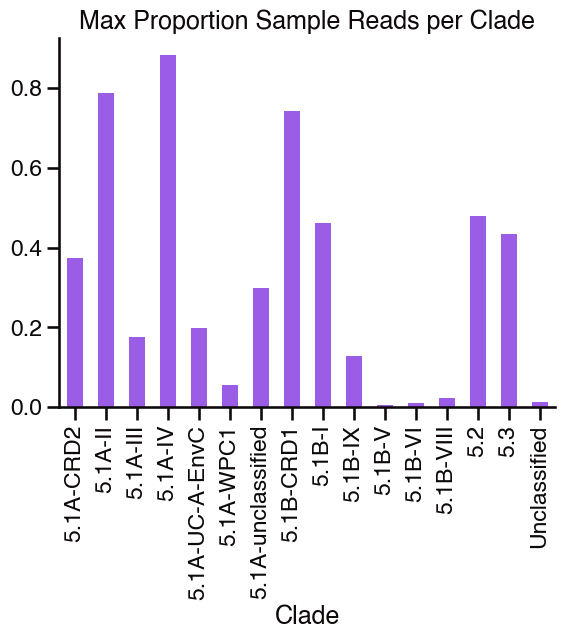

In [14]:
# get Syn community composition data together

syn_comp_df = comp_df[comp_df['Group'] == 'Synechococcus']
syn_comp_df = syn_comp_df.groupby(['SampleName', 'Clade'])['CladeProportionReads'].mean().reset_index()
max_reads = syn_comp_df.groupby('Clade').CladeProportionReads.max()
print(max_reads * 100)
max_reads.plot(kind='bar', title='Max Proportion Sample Reads per Clade')

# replace low abundance clades with "other" label
others = ['5.1A-WPC1', '5.1B-V', '5.1B-VI', '5.1B-VIII', 'Unclassified']
syn_comp_df.loc[syn_comp_df['Clade'].isin(others), 'Clade'] = 'Other'
syn_comp_df = syn_comp_df.groupby(['SampleName', 'Clade'])['CladeProportionReads'].sum().reset_index()
max_other = syn_comp_df.loc[syn_comp_df[syn_comp_df.Clade == 'Other'].CladeProportionReads.idxmax(), :]
print(f"\nClades combined as 'Other': {others}")
print(f"Max proportion 'Other' reads: {max_other['CladeProportionReads']*100:.2f}% in sample {max_other['SampleName']}\n")

# add back sample metadata
syn_comp_df = pd.merge(syn_comp_df, sample_df, on='SampleName', how='left')
    

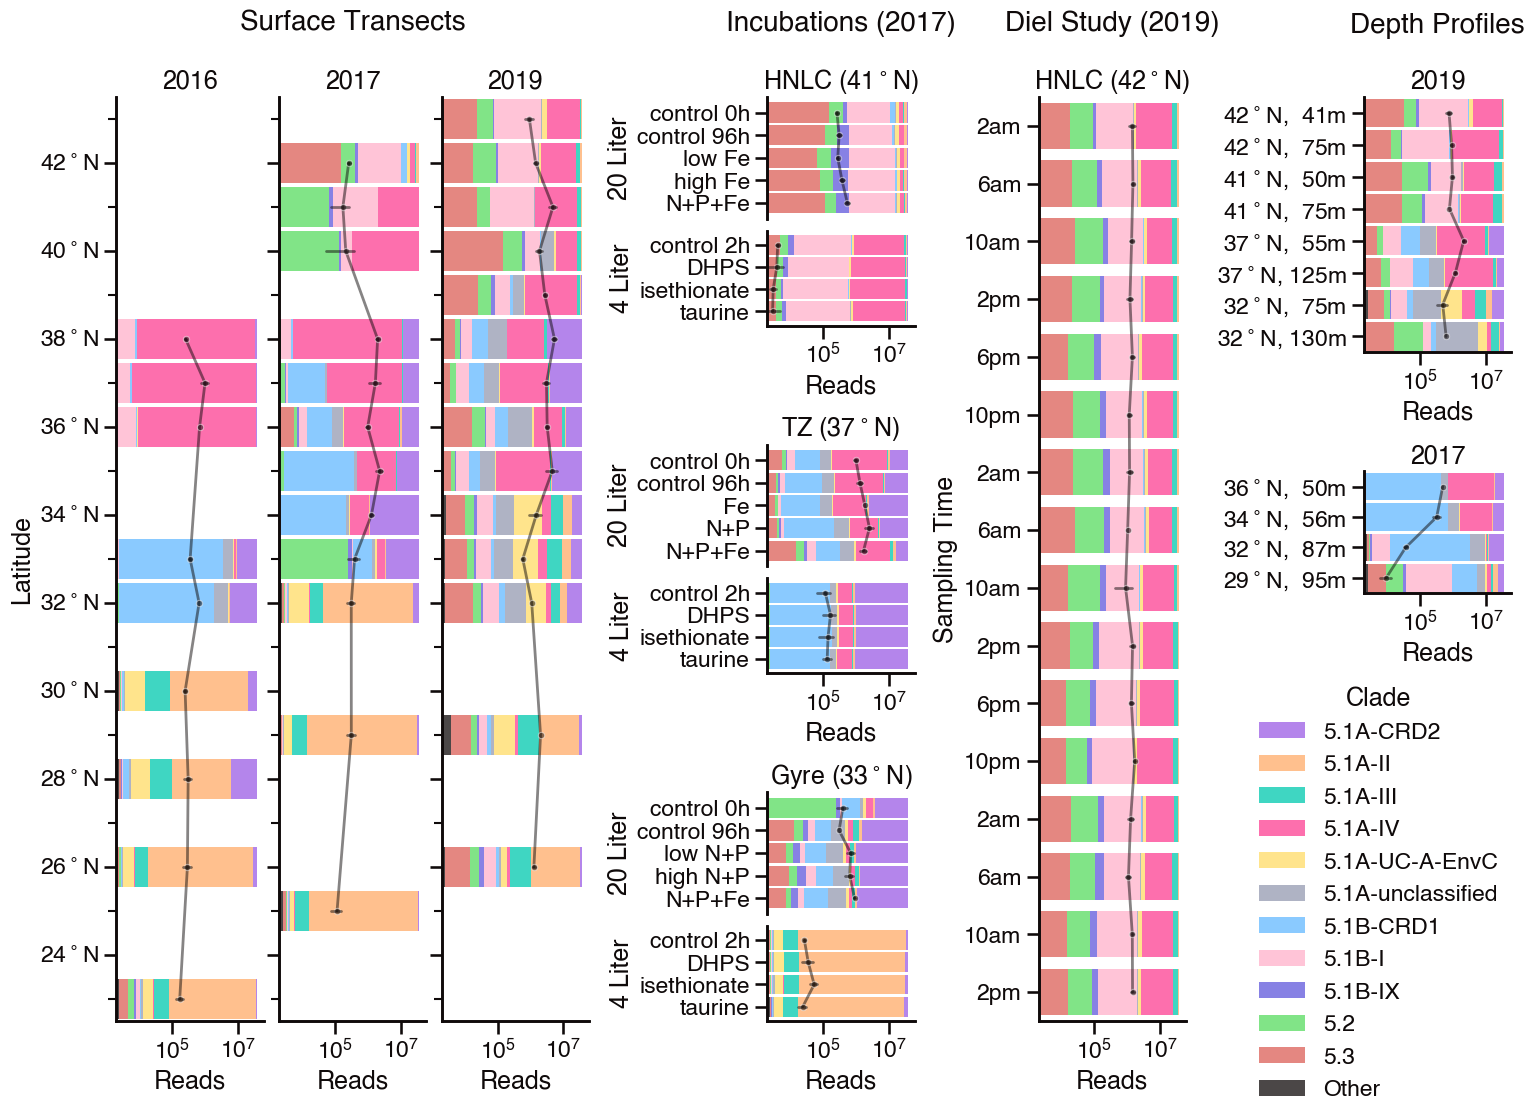

In [15]:
# Plot Synechococcus commmunity abundances

# set up figure
fig = plt.figure(figsize=(18, 12))
rows = 35
cols = 26
grid = plt.GridSpec(rows, cols, wspace=0.4, hspace=.8)
xlim = (2000, 60000000)
color_palette = [sns.color_palette()[i] for i in [0, 1, 2, 3, 6, 5, 7, 8]] + \
    [sns.color_palette('hls', 6)[i] for i in [4, 2, 0]] + [sns.color_palette()[4]]
annot_kwgs = {
    'xycoords': 'axes fraction', 'va': 'center', 'ha': 'left', 'fontsize': 22, 'annotation_clip': False
}

# plot surface transect data
n_bins = 21
bounds = (23, 43)
for i, year in enumerate([2016, 2017, 2019]):
    axis = plt.subplot(grid[:, 3*i:3*(i+1)])
    if i == 1:
        axis.annotate('Surface Transects', xy=(.5, 1.08), xycoords='axes fraction', va='center', ha='center', fontsize=20)
    # plot community composition
    plot_df = syn_comp_df[(syn_comp_df['Year'] == year) & (syn_comp_df['SampleGroup'] == 'surface transect')]
    latitudes = plot_df[
        ['SampleName', 'Latitude']].drop_duplicates().set_index('SampleName').sort_values('Latitude')['Latitude']
    lat_bins = unique_bins(latitudes, n_bins, bounds=bounds, reverse=False)
    plot_df['lat_idx'] = plot_df['SampleName'].map(dict(zip(latitudes.index, lat_bins)))
    sns.histplot(
        data=plot_df, y='lat_idx', hue='Clade', weights='CladeProportionReads', multiple='stack', 
        palette=color_palette, bins=n_bins, binrange=(-0.5, n_bins-0.5), legend=False, shrink=0.9, ax=axis
    )
    if not i:
        axis.set_yticks(np.arange(1, n_bins, 2), [f'{l}$^\circ$N' for l in np.arange(bounds[0]+1, bounds[1], 2)])
        axis.set(xlabel='', ylabel='Latitude', ylim=(-0.5, n_bins-0.5), title=year)
    else: 
        axis.set_yticks(np.arange(1, n_bins, 2))
        axis.tick_params(labelleft=False)
        axis.set(xlabel='', ylabel='', ylim=(-0.5, n_bins-0.5), title=year)
    axis.set_yticks(np.arange(n_bins), minor=True)
    # plot total read abundance
    plot_df = syn_abun_df[(syn_abun_df['Year'] == year) & (syn_abun_df['SampleGroup'] == 'surface transect')]
    plot_df['lat_idx'] = plot_df['SampleName'].map(dict(zip(latitudes.index, lat_bins)))
    axis2 = plt.twiny(axis)
    sns.lineplot(
        plot_df, x='GenusReads', y='lat_idx', estimator='mean', errorbar='sd', err_style='bars', orient='y', 
        color=sns.color_palette()[4], alpha=0.5, marker='.', ax=axis2
    )
    axis.tick_params(bottom=False, labelbottom=False)
    axis2.xaxis.set_label_position('bottom')
    axis2.xaxis.tick_bottom()
    axis2.set(xscale='log', xlabel='Reads', xlim=xlim)

# plot incubation data
incubation_treatment_order = {
    'HNLC': {'rr': ['control 0h', 'control 96h', 'low Fe', 'high Fe', 'N+P+Fe'], 'bryn': ['control 2h', 'DHPS', 'isethionate', 'taurine']}, 
    'TZ': {'rr': ['control 0h', 'control 96h', 'Fe', 'N+P', 'N+P+Fe'], 'bryn': ['control 2h', 'DHPS', 'isethionate', 'taurine']}, 
    'gyre': {'rr': ['control 0h', 'control 96h', 'low N+P', 'high N+P', 'N+P+Fe'], 'bryn': ['control 2h', 'DHPS', 'isethionate', 'taurine']}
}
inc_titles = {
    'rr': {'HNLC': 'HNLC (41$^\circ$N)', 'TZ': 'TZ (37$^\circ$N)', 'gyre': 'Gyre (33$^\circ$N)'}, 
    'bryn': {'HNLC': '', 'TZ': '', 'gyre': ''}
}
for i, condition in enumerate(['HNLC', 'TZ', 'gyre']):
    axtop = plt.subplot(grid[13*i:5+(13*i), 12:15]) # 0:5, 13:18, 26:31
    axbottom = plt.subplot(grid[5+(13*i):9+(13*i), 12:15]) # 5:9, 18:22, 31:35
    if not i:
        axtop.annotate('Incubations (2017)', xy=(0.5, 1.6), xycoords='axes fraction', 
                      va='center', ha='center', fontsize=20)
    # get data togehter
    comp_data_df = syn_comp_df[syn_comp_df['Condition'] == condition]
    abun_data_df = syn_abun_df[syn_abun_df['Condition'] == condition]
    for dataset in ['rr', 'bryn']:
        axis = {'rr': axtop, 'bryn': axbottom}[dataset]
        if dataset == 'rr':
            comp_plot_df = comp_data_df[comp_data_df['Dataset'] != 'Bryn amendment incubation']
            abun_plot_df = abun_data_df[abun_data_df['Dataset'] != 'Bryn amendment incubation']
        elif dataset == 'bryn':
            comp_plot_df = comp_data_df[comp_data_df['Dataset'] == 'Bryn amendment incubation']
            abun_plot_df = abun_data_df[abun_data_df['Dataset'] == 'Bryn amendment incubation']
        # plot composition
        comp_plot_df['Treatment'] = pd.Categorical(comp_plot_df['Treatment'], incubation_treatment_order[condition][dataset])
        sns.histplot(
            data=comp_plot_df.sort_values(['Treatment', 'Clade']), y='Treatment', hue='Clade', weights='CladeProportionReads', 
            multiple='stack', palette=color_palette, legend=False, shrink=0.9, ax=axis
        )
        # plot total read abundance
        axis2 = plt.twiny(axis)
        abun_plot_df['Treatment'] = pd.Categorical(abun_plot_df['Treatment'], incubation_treatment_order[condition][dataset])
        sns.lineplot(
            abun_plot_df.sort_values('Treatment'), x='GenusReads', y='Treatment', estimator='mean', errorbar='sd', err_style='bars', 
            orient='y', color=sns.color_palette()[4], alpha=0.5, marker='.', ax=axis2
        )
        # fix labels and ticks
        axis.set(xlabel='', ylabel={'rr': '20 Liter', 'bryn': '4 Liter'}[dataset], title=inc_titles[dataset][condition])
        axis.tick_params(bottom=False, labelbottom=False)
        axis2.xaxis.set_label_position('bottom')
        axis2.xaxis.tick_bottom()
        if dataset == 'rr':
            axis.spines[['bottom']].set_visible(False)
            axis2.spines[['bottom']].set_visible(False)
            axis2.set(xscale='log', xlabel='', xlim=xlim)
            axis2.tick_params(bottom=False, labelbottom=False, which='both')
        elif dataset == 'bryn':
            axis2.set(xscale='log', xlabel='Reads', xlim=xlim)

# plot diel data
axis = plt.subplot(grid[:, 17:20])
axis.annotate('Diel Study (2019)', xy=(0.5, 1.08), xycoords='axes fraction', va='center', ha='center', fontsize=20)
# plot community composition
plot_df = syn_comp_df[syn_comp_df['SampleGroup'] == 'diel study'].sort_values(['Datetime', 'Clade'], ascending=[False, True])
n_samples = plot_df['SampleName'].nunique()
plot_df['idx'] = plot_df['SampleName'].map(dict(zip(plot_df['SampleName'].unique(), np.arange(n_samples))))
sns.histplot(
    data=plot_df, y='idx', hue='Clade', weights='CladeProportionReads', 
    multiple='stack', palette=color_palette, bins=n_samples, binrange=(-0.5, n_samples-0.5), legend=False, shrink=0.8, ax=axis
)
axis.set(xlabel='', ylabel='Sampling Time', ylim=(-0.5, n_samples-0.5), title='HNLC (42$^\circ$N)')
axis.set_yticks(np.arange(n_samples), plot_df[['SampleName', 'TimeClass']].drop_duplicates()['TimeClass']);
# plot total read abundance
axis2 = plt.twiny(axis)
plot_df = syn_abun_df[syn_abun_df['SampleGroup'] == 'diel study'].sort_values('Datetime', ascending=False)
plot_df['idx'] = plot_df['SampleName'].map(dict(zip(plot_df['SampleName'].unique(), np.arange(n_samples))))
sns.lineplot(
    plot_df, x='GenusReads', y='idx', estimator='mean', errorbar='sd', err_style='bars', 
    orient='y', color=sns.color_palette()[4], alpha=0.5, marker='.', ax=axis2
)
axis.tick_params(bottom=False, labelbottom=False)
axis2.xaxis.set_label_position('bottom')
axis2.xaxis.tick_bottom()
axis2.set(xscale='log', xlabel='Reads', xlim=xlim)

# plot depth data
for i, year in enumerate([2019, 2017]):
    axis = plt.subplot(grid[i*14:10+(i*9), 23:])
    if not i:
        axis.annotate('Depth Profiles', xy=(0.5, 1.28), xycoords='axes fraction', va='center', ha='center', fontsize=20)
    # plot community composition
    plot_df = syn_comp_df[(syn_comp_df['SampleGroup'] == 'depth profiles') & (pro_comp_df['Year'] == year)].sort_values(
        ['Latitude', 'Depth', 'Clade'], ascending=[True, False, True])
    n_samples = plot_df['SampleName'].nunique()
    plot_df['idx'] = plot_df['SampleName'].map(dict(zip(plot_df['SampleName'].unique(), np.arange(n_samples))))
    sns.histplot(data=plot_df, y='idx', hue='Clade', weights='CladeProportionReads', 
        multiple='stack', palette=color_palette, bins=n_samples, binrange=(-0.5, n_samples-0.5), legend=i, shrink=0.9, ax=axis
    )
    axis.set(xlabel='', ylabel='', ylim=(-0.5, n_samples-0.5), title=year)
    label_df = plot_df[['SampleName', 'Depth', 'Latitude']].drop_duplicates()
    labels = [f"{int(r['Latitude'])}$^\circ$N,{r['Depth']:4}m" for _, r in label_df.iterrows()]
    axis.set_yticks(np.arange(n_samples), labels);
    # plot total read abundance
    axis2 = plt.twiny(axis)
    plot_df = syn_abun_df[(syn_abun_df['SampleGroup'] == 'depth profiles') & (syn_abun_df['Year'] == year)].sort_values(
        ['Latitude', 'Depth'], ascending=[True, False])
    plot_df['idx'] = plot_df['SampleName'].map(dict(zip(plot_df['SampleName'].unique(), np.arange(n_samples))))
    sns.lineplot(
        plot_df, x='GenusReads', y='idx', estimator='mean', errorbar='sd', err_style='bars', 
        orient='y', color=sns.color_palette()[4], alpha=0.5, marker='.', ax=axis2
    )
    axis.tick_params(bottom=False, labelbottom=False)
    axis2.xaxis.set_label_position('bottom')
    axis2.xaxis.tick_bottom()
    axis2.set(xscale='log', xlabel='Reads', xlim=xlim)

# fix the legend
legend = axis.get_legend()
legend.set(loc='upper center', bbox_to_anchor=(0.1, -.6));

# save figure
fig.savefig(out_dir / 'syn-reads-by-clade.png', bbox_inches='tight')
